In [158]:
import pandas as pd
import config as c
import postgres as p
from main import connect_db

import warnings
warnings.filterwarnings('ignore')
from pandasql import sqldf
from main import sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sql = lambda q: sqldf(q, globals())


In [159]:
con = connect_db(host_name = c.HOST_NAME, dbname=c.DBNAME, port=c.PORT, 
                      username=c.USERNAME, password= c.PASSWORD)
curr = con.cursor() 

Connected!


Fetching data from the database

In [160]:

string = """SELECT country_code, country, sub_region,
                    intermediate_region,household_net_wealth, personal_earnings, quality_support_network,mg_m3, water_quality_percentage,
                    
                    life_expectancy, student_scores, leisure_time, life_satisfaction_score 
                    
                    FROM happiness"""


df = pd.read_sql(string, con,)

df.head()


,country_code,country,sub_region,intermediate_region,household_net_wealth,personal_earnings,quality_support_network,mg_m3,water_quality_percentage,life_expectancy,student_scores,leisure_time,life_satisfaction_score
0,AUS,Australia,Oceania,Australia and New Zealand,528768.0,55206.0,93.0,6.7,92.0,83.0,499.0,14.360,7.1
1,AUT,Austria,Europe,Western Europe,309637.0,53132.0,92.0,12.2,92.0,82.0,491.0,14.510,7.2
2,BEL,Belgium,Europe,Western Europe,447607.0,54327.0,90.0,12.8,79.0,82.1,500.0,15.520,6.8
3,CAN,Canada,Americas,Northern America,478240.0,55342.0,93.0,7.1,90.0,82.1,517.0,14.570,7.0
4,CHL,Chile,Americas,Latin America and the Caribbean,135787.0,26729.0,88.0,23.4,62.0,80.6,438.0,14.974,6.2


In [161]:
#How many countries in each region?
sql(
    """
    SELECT d.sub_region as 'Region', count(1) as 'Number of countries'

    FROM df as d
    GROUP BY d.sub_region    
    """)

,Region,Number of countries
0,Africa,1
1,Americas,7
2,Asia,4
3,Europe,27
4,Oceania,2


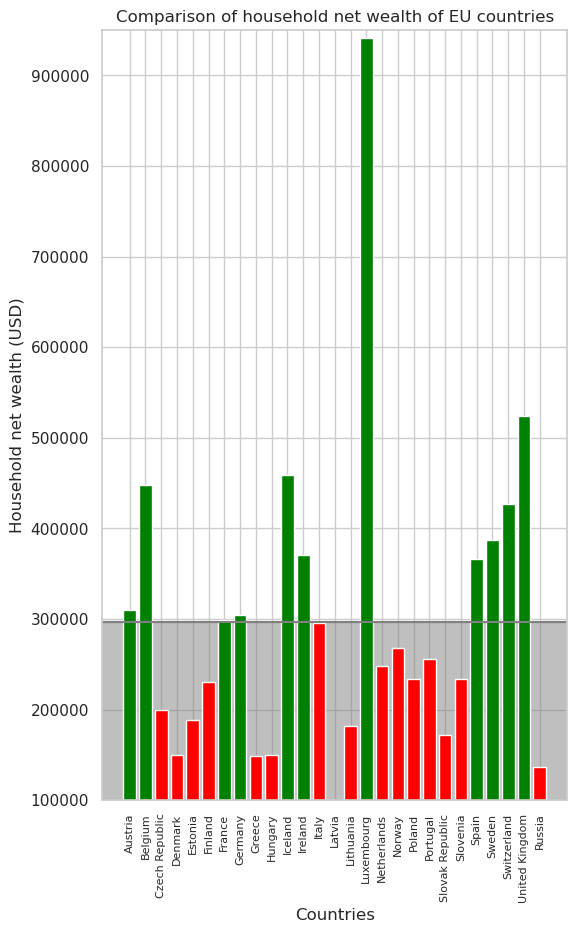

In [162]:
#comparison of european countries
df_compare_eusubregion = sql(
    """
    SELECT d.country, d.household_net_wealth as household_net_wealth,
    (select round(avg(household_net_wealth),0) from df as e where e.sub_region = d.sub_region) as sub_region_avg
    FROM df as d
    where d.sub_region = 'Europe';
    """)

sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (6,10))

df_compare_eusubregion['colour'] = np.where(df_compare_eusubregion['household_net_wealth'] >=  df_compare_eusubregion.sub_region_avg \
                                            ,'green', 'red')

line = ax.axhline(y = df_compare_eusubregion['sub_region_avg'].values[0], c = 'gray')
ax.fill_between(np.linspace(-100,100,len(df_compare_eusubregion.country)),
                 df_compare_eusubregion.sub_region_avg, color = 'grey', alpha = 0.5)

ax.bar(x= df_compare_eusubregion.country, height= df_compare_eusubregion.household_net_wealth, color = df_compare_eusubregion['colour'] 
            )

plt.xticks(rotation = 90, fontsize = 8);
plt.ylim((100000,950000))
ax.set_title('Comparison of household net wealth of EU countries')
ax.set_xlabel('Countries')
ax.set_ylabel('Household net wealth (USD)');